# LIBRARY

In [ ]:
# Data Processing
import numpy as np
import pandas as pd
import datetime as dt

# Data Visualizing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display, HTML
from IPython.display import Image

# Data Clustering
from mlxtend.frequent_patterns import apriori # Data pattern exploration
from mlxtend.frequent_patterns import association_rules # Association rules conversion

# Data Modeling
from sklearn.ensemble import RandomForestRegressor

# Math
from scipy import stats  # Computing the t and p values using scipy 
from statsmodels.stats import weightstats 

# Warning Removal
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

# DATA EXPLORATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_ = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = df_.copy()

In [ ]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [ ]:
df.shape

(541910, 8)

# DATA MANIPULATION

### Check for any Duplicated Rows

In [ ]:
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)

5268


The post statement in the stock code shows the postage cost, let's delete it as it is not a product:

In [ ]:
df = df[~df["StockCode"].str.contains("POST", na=False)]

### Description
- For any StockCode, there is one specific description along.

In [ ]:

def cleaning_description(df):
    try: 
        return df.mode()[0] # df.mode().iloc[0]
    except Exception:
        return 'unknown'
    
df[['StockCode', 'Description']] = df[['StockCode', 'Description']].fillna(df[['StockCode', 'Description']].groupby('StockCode').transform(cleaning_description))

# Cleaning Description field for proper aggregation
df['Description'] = df['Description'].str.strip().copy()

### Invoice Number
- Invoice Number should be in a form of 6-digit integral number. If the code starts with a letter C, it shows the invoice is cancelled.
- However, some codes that don't start with the letter C are categorized with cancellation by a negative number from Quantity feature.
- Thus, cleaning the starting letter C is right.

In [ ]:
df_Invoice = pd.DataFrame({"Invoice":[row for row in df["Invoice"].values if "C"  not in str(row)]})
df_Invoice.head()
df_Invoice = df_Invoice.drop_duplicates("Invoice")

In [ ]:
df = df.merge(df_Invoice, on = "Invoice")

### Quantity
- Most invoices cluster around 0, in a range of [-10000, 10000].
- There are some outliers way above and below the range above. We can safely remove for the sake of revenue analysis.

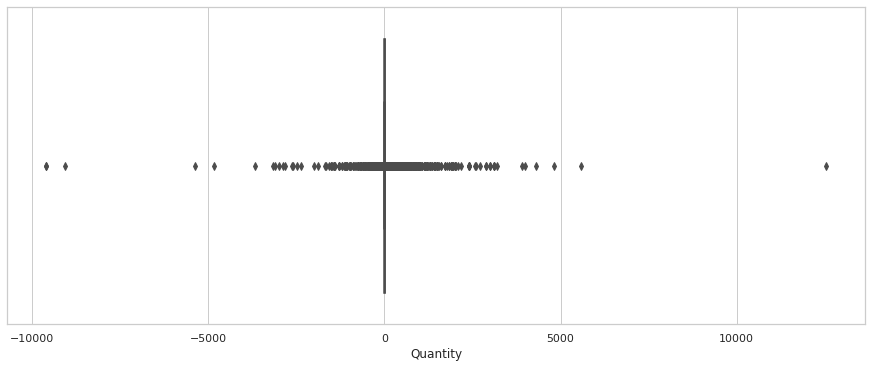

In [ ]:
# Plot Quantity
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.boxplot(df['Quantity'])

# remove outliers for Quantity
df = df[(df['Quantity'] < 15000) & (df['Quantity'] > -15000)]

### InvoiceDate
- Applying feature extraction on InvoiceDate to get new features such as date, day, month, year, hour, day of week for further analysis.

In [ ]:
# Change datatype of InvoiceDate as datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# df['date'] = pd.to_datetime(df['InvoiceDate'], utc=False)
# df['date'].dtypes

# Create new features
df['date'] = df['InvoiceDate'].dt.date   # df['date'].dt.normalize()  # Show only date
df['day'] = df['InvoiceDate'].dt.day
df['month'] = df['InvoiceDate'].dt.month
df['year'] = df['InvoiceDate'].dt.year
df['hour'] = df['InvoiceDate'].dt.hour
df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
df['dayofweek'] = df['dayofweek'].map( {0: '1_Mon', 1: '2_Tue', 2: '3_Wed', 3: '4_Thur', 4: '5_Fri', 5: '6_Sat', 6: '7_Sun'})

### UnitPrice
- Generally, unit price is at least 0, thus any unit price is below the baseline is considered as outliers.

In [ ]:
# Clean UnitPrice
''' 
Steps to clean Unit Price
    df['UnitPrice'].describe()
    df[df['UnitPrice'] < 0]
    sns.boxplot(df['UnitPrice'])
    sns.distplot(df['UnitPrice'])
    df[df['StockCode'] == 'M']
    df[df['UnitPrice'] > 15000]
'''
df = df[df['Price'] >= 0]

### CustomerID
- There are multiple unknown customers, yet we know from which country the invoice comes from. Thus, we should fill missing value of customerID with 'unknown' rather than filtering out those rows containing unknown customerID.

In [ ]:
# Fill CustomerID with unknown
df['Customer ID'].dropna(inplace=True)

### Revenue
- Revenue is the product of UnitPrice and Quantity from each transaction.

In [ ]:
# Create a new feature Revenue
df['Revenue'] = df['Price'] * df['Quantity']

# DATA ANALYSIS
For the curiosity of data, we conduct a depth analysis based on our following questions:
1. Who, customerID, bring most revenue?
2. Who, customerID, buy most in term of quantity?
3. Which item is bought most and least?
4. Which country bring most revenue in total and average?
5. Which month we sell out most and least?
6. What time people tend to buy our product?
7. Which day of a week people tend to visit and purchase stuff?
8. Are there any relationship between Repeat Customers and All Customers over a year?
9. What is the most trending of some items?

### Question 1 and 2: Who, customerID, bring most revenue? And, who, customerID, buy most in term of quantity?
- We notice CustomerID of 14646 bring \\$279489 in total, and an amount of each transaction is around \\$134. A total number of items are bought from this customer is 196719, 
-However the unit price for each item is approximately \\$2.6.
 

In [ ]:
CustomerID_Rev = df.groupby('Customer ID')[['Revenue',
                          'Quantity',
                          'Price']].agg(['sum',
                                             'mean',
                                             'median']).sort_values(by=[('Revenue', 'sum')], ascending=False)
display(CustomerID_Rev.reset_index())

display(pd.DataFrame(CustomerID_Rev.iloc[1:][('Revenue','sum')].describe()))


Customer ID    Revenue                     Quantity                \
                        sum        mean  median      sum          mean   
0        14646.0  280206.02  134.714433  105.60   197491     94.947596   
1        18102.0  259657.30  602.453132  394.80    64124    148.779582   
2        17450.0  194390.79  578.544018  294.48    69973    208.252976   
3        14911.0  143711.17   25.336948   17.00    80490     14.190762   
4        12415.0  124914.53  174.461634  135.00    77670    108.477654   
...          ...        ...         ...     ...      ...           ...   
4333     16454.0       6.90    3.450000    3.45        3      1.500000   
4334     14792.0       6.20    3.100000    3.10        2      1.000000   
4335     16738.0       3.75    3.750000    3.75        3      3.000000   
4336     16446.0       2.90    1.450000    1.45        2      1.000000   
4337     13256.0       0.00    0.000000    0.00    12540  12540.000000   

                  Price                   
       median       sum      mean median  
0        72.0   5176.09  2.488505  1.450  
1       108.0   1940.92  4.503295  4.270  
2        96.0   1135.32  3.378929  2.550  
3        10.0  26150.35  4.610428  2.100  
4        96.0   2097.08  2.928883  1.650  
...       ...       ...       ...    ...  
4333      1.5      3.95  1.975000  1.975  
4334      1.0      6.20  3.100000  3.100  
4335      3.0      1.25  1.250000  1.250  
4336      1.0      2.90  1.450000  1.450  
4337  12540.0      0.00  0.000000  0.000  

[4338 rows x 10 columns]

,Revenue
,sum
count,4337.000000
mean,1927.915074
std,7430.122927
min,0.000000
25%,306.130000
50%,667.650000
75%,1654.310000
max,259657.300000


 Question 3: Which item is bought most and least?
- StockCode of 22197 and 84007 are leading at the price of 0.72, 0.29 & 0.21. This somehow can explain if the unit price is low, people are able to afford more.
- There are about 13 least preferred items among all.
- Some items with negative quantity figure are not considered in this analysis, because those items were bought before the period of this dataset, probably in 2009 and they were returned in 2010 or 2011. Thus, we have not enough evidence to analyze. 

In [ ]:
most_prefered_items = df.groupby(['StockCode', 'Price'])[['Quantity']].sum().sort_values(by=['Quantity'],ascending=False).head(10)

most_prefered_items

Quantity
StockCode Price          
22197     0.72      36136
84077     0.29      27780
          0.21      23904
84879     1.69      22434
85123A    2.55      20030
23084     1.79      19985
85099B    1.79      19136
21212     0.55      17829
22492     0.65      17006
22197     0.85      13452

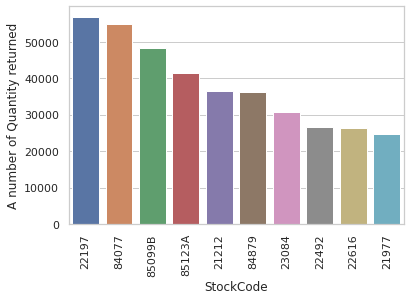

,Quantity
StockCode,
22197,56898
84077,54951
85099B,48375
85123A,41389
21212,36396
84879,36202
23084,30705
22492,26633
22616,26323


Quantity
StockCode Price          
22197     0.72      36136
84077     0.29      27780
          0.21      23904
84879     1.69      22434
85123A    2.55      20030
23084     1.79      19985
85099B    1.79      19136
21212     0.55      17829
22492     0.65      17006
22197     0.85      13452

In [ ]:
most_prefered_items1 = df.groupby(['StockCode'])[['Quantity']].sum().sort_values(by=['Quantity'],ascending=False).head(10)

most_prefered_items2 = df.groupby(['StockCode', 'Price'])[['Quantity']].sum().sort_values(by=['Quantity'],ascending=False).head(10)

sns.barplot(x=most_prefered_items1.index, y=most_prefered_items1['Quantity'])
plt.ylabel('A number of Quantity returned')
plt.xticks(rotation=90)
plt.show()

display(most_prefered_items1)
display(most_prefered_items2)

In [ ]:
least_prefered_items = df.groupby(['StockCode'])[['Quantity']].sum().sort_values(by=['Quantity'],ascending=False)
least_prefered_items = least_prefered_items[least_prefered_items['Quantity']==0]
print('A list of least preferred items: ', len(least_prefered_items))
least_prefered_items

A list of least preferred items:  13


,Quantity
StockCode,
22528,0
84840,0
20954,0
47579,0
84593,0
85119,0
84227,0
21011,0
72815,0


### Question 4: Which country bring most revenue in total and average?
- This is the e-commerce UK-based online retail, so United Kingdom brings most revenue and quantity.
- However, Netherlands only comes as the second place, but spend quite much, around \\$120 with 84 in quantity for each transaction.
- Average UnitPrices per Invoice from Singapore and HongKong, around \\$109 and \\$42, outstand from that of rest, only between \\$2 and \\$8.5 

In [ ]:
InvoiceNumber_Country = pd.DataFrame(df.groupby(['Country'])['Invoice'].count())

fig = go.Figure(data=go.Choropleth(
                locations=InvoiceNumber_Country.index, # Spatial coordinates
                z = InvoiceNumber_Country['Invoice'].astype(float), # Data to be color-coded
                locationmode = 'country names', # set of locations match entries in `locations`
                colorscale = 'Reds',
                colorbar_title = "Order number",
            ))

fig.update_layout(
    title_text = 'Order number per country',
    geo = dict(showframe = True, projection={'type':'mercator'})
)
fig.layout.template = None
fig.show()

Revenue                   
                              sum        mean median
Country                                             
United Kingdom        8756090.894   18.148279   8.47
Netherlands            285446.340  120.798282  91.80
EIRE                   283140.520   35.917864  17.40
Germany                228678.400   25.332713  17.00
France                 209643.370   24.975384  16.60
Australia              138453.810  116.937340  66.00
Spain                   61558.560   24.822000  15.00
Switzerland             57067.600   29.130985  17.70
Belgium                 41196.340   20.283772  16.60
Sweden                  38367.830   85.261844  32.25
Japan                   37416.370  116.561900  70.20
Norway                  36165.440   33.736418  19.80
Portugal                33683.050   22.575771  15.90
Finland                 22546.080   32.913985  17.85
Singapore               21279.290   95.852658  36.75
Channel Islands         20440.540   27.363507  17.70
Denmark                 18955.340   49.882474  23.40
Italy                   17483.240   23.064960  17.70
Hong Kong               15483.000   55.296429  23.40
Cyprus                  13502.850   22.392786  16.50
Austria                 10198.680   25.624824  17.17
Israel                   8129.410   27.840445  18.00
Poland                   7334.650   22.226212  17.40
Greece                   4760.520   32.831172  16.60
Unspecified              4740.940   10.726109   8.95
Iceland                  4310.000   23.681319  17.00
Canada                   3666.380   24.280662  16.50
USA                      3580.390   20.002179  16.60
Malta                    2725.590   24.335625  17.20
United Arab Emirates     1902.280   27.974706  20.40
Lebanon                  1693.880   37.641778  31.60
Lithuania                1661.060   47.458857  45.00
European Community       1300.250   21.670833  17.70
Brazil                   1143.600   35.737500  19.65
RSA                      1002.310   17.281207  16.50
Czech Republic            826.740   33.069600  31.20
Bahrain                   754.140   41.896667  25.50
Saudi Arabia              145.920   16.213333  17.70

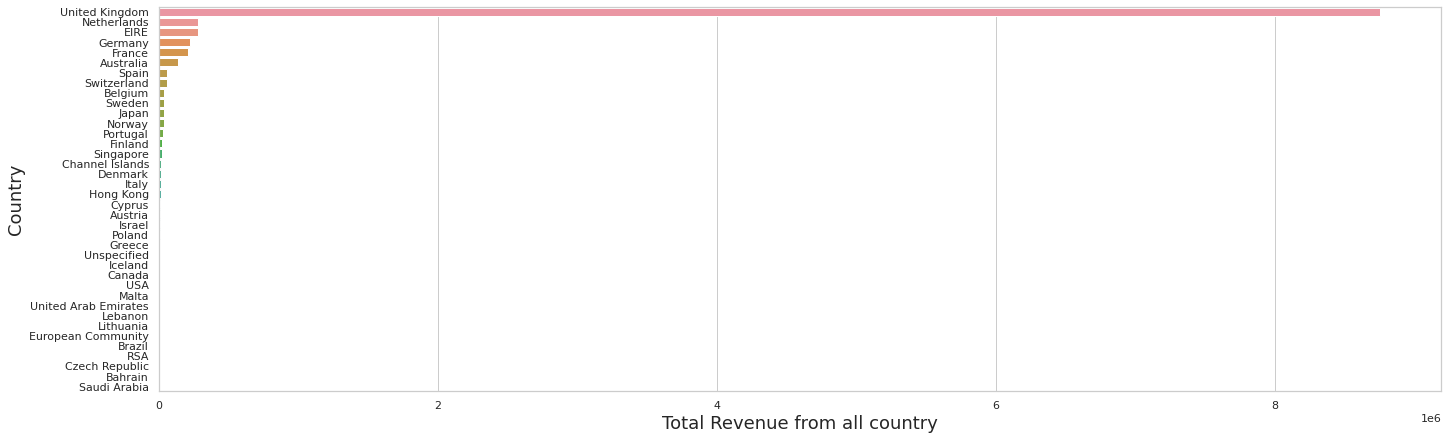

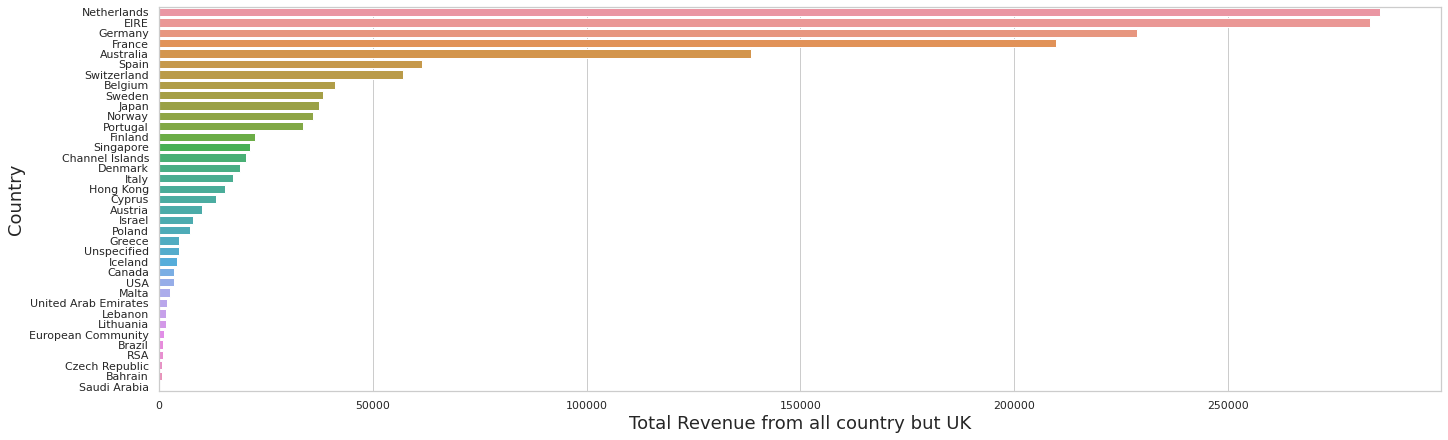

In [ ]:

country_revenue = df.groupby('Country')[['Revenue']].agg(['sum',
                                        'mean',
                                        'median']).sort_values(by=[('Revenue', 'sum')], ascending=False)
display(country_revenue)

fig = plt.figure(constrained_layout=True, figsize=(20, 6))
a = sns.barplot(y=country_revenue.index, x=country_revenue[('Revenue', 'sum')])
plt.xlabel('Total Revenue from all country', fontsize=18)
plt.ylabel('Country', fontsize=18)


fig = plt.figure(constrained_layout=True, figsize=(20, 6))
country_revenue = country_revenue.drop('United Kingdom')
sns.barplot(y=country_revenue.index, x=country_revenue[('Revenue', 'sum')])
plt.xlabel('Total Revenue from all country but UK', fontsize=18)
plt.ylabel('Country', fontsize=18)
plt.show()



Quantity                  
                          sum       mean median
Country                                        
United Kingdom        4356160   9.028779    3.0
Netherlands            200937  85.034702   72.0
EIRE                   147281  18.683369   12.0
Germany                119156  13.199956   10.0
France                 112062  13.350250   10.0
Australia               84199  71.114020   32.0
Sweden                  36078  80.173333   24.0
Switzerland             30618  15.629403   12.0
Spain                   27944  11.267742    6.0
Japan                   26016  81.046729   48.0
Belgium                 23237  11.441162   10.0
Norway                  19338  18.039179   12.0
Portugal                16231  10.878686    9.5
Finland                 10704  15.626277   10.0
Channel Islands          9485  12.697456   10.0
Denmark                  8235  21.671053   12.0
Italy                    8112  10.701847    8.0
Cyprus                   6340  10.514096    6.0
Singapore                5241  23.608108   12.0
Austria                  4881  12.263819   10.0
Hong Kong                4713  16.832143   12.0
Israel                   4406  15.089041   12.0
Poland                   3684  11.163636   10.0
Unspecified              3295   7.454751    3.5
Canada                   2763  18.298013   12.0
USA                      2458  13.731844   12.0
Iceland                  2458  13.505495   12.0
Greece                   1557  10.737931   10.0
United Arab Emirates      982  14.441176   12.0
Malta                     970   8.660714    6.0
Czech Republic            671  26.840000   24.0
Lithuania                 652  18.628571   16.0
European Community        499   8.316667    6.0
Lebanon                   386   8.577778    8.0
Brazil                    356  11.125000   10.0
RSA                       352   6.068966    6.0
Bahrain                   314  17.444444    6.0
Saudi Arabia               80   8.888889   12.0

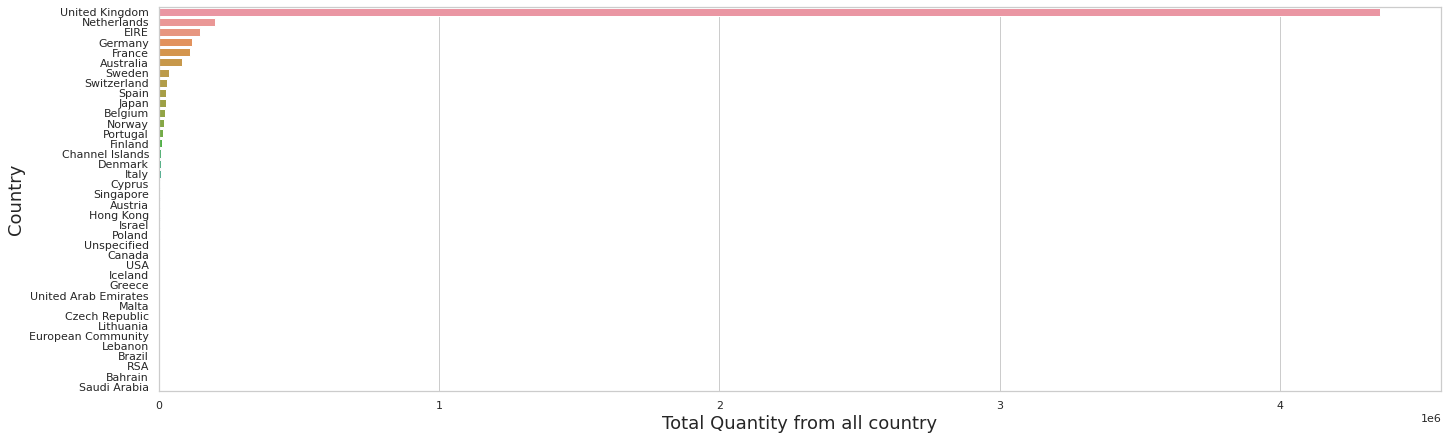

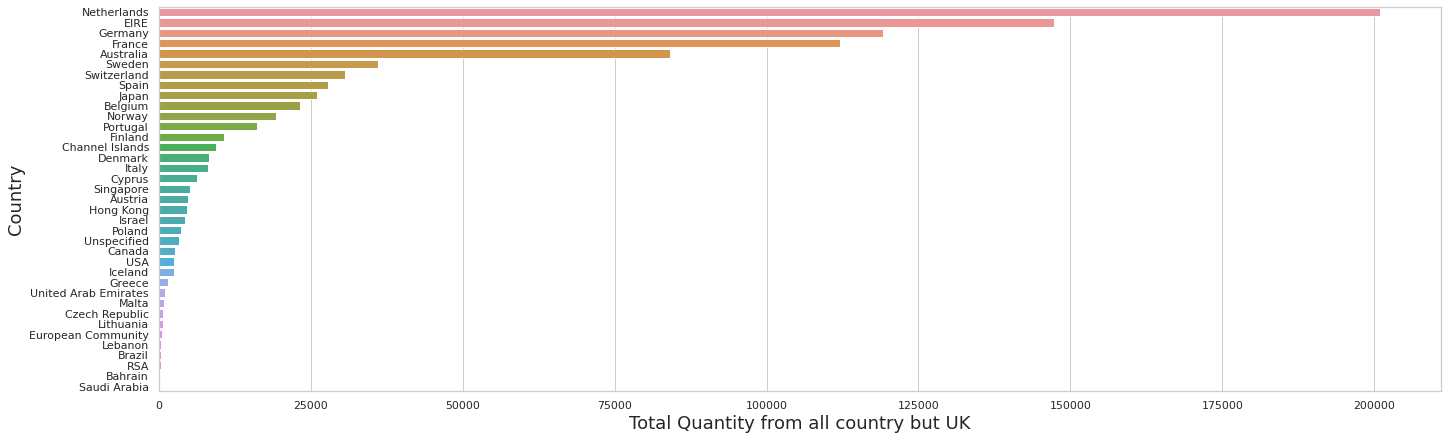

In [ ]:
country_quantity = df.groupby('Country')[['Quantity']].agg(['sum',
                                        'mean',
                                        'median']).sort_values(by=[('Quantity', 'sum')], ascending=False)

display(country_quantity)

fig = plt.figure(constrained_layout=True, figsize=(20, 6))
a = sns.barplot(y=country_quantity.index, x=country_quantity[('Quantity', 'sum')])
plt.xlabel('Total Quantity from all country', fontsize=18)
plt.ylabel('Country', fontsize=18)


fig = plt.figure(constrained_layout=True, figsize=(20, 6))
country_quantity = country_quantity.drop('United Kingdom')
sns.barplot(y=country_quantity.index, x=country_quantity[('Quantity', 'sum')])
plt.xlabel('Total Quantity from all country but UK', fontsize=18)
plt.ylabel('Country', fontsize=18)
plt.show()

Price           
                              sum       mean
Country                                     
Singapore               12949.990  58.333288
Hong Kong                6649.640  23.748714
Canada                    910.580   6.030331
Portugal                 8744.110   5.860664
Cyprus                   3466.150   5.748176
Lebanon                   242.440   5.387556
Finland                  3628.440   5.296993
Norway                   5662.470   5.282155
EIRE                    38444.380   4.876872
Malta                     545.190   4.867768
European Community        289.800   4.830000
Italy                    3576.210   4.717955
Bahrain                    82.760   4.597778
Greece                    663.290   4.574414
Channel Islands          3388.000   4.535475
Brazil                    142.600   4.456250
France                  36967.730   4.404066
RSA                       248.100   4.277586
Austria                  1693.900   4.256030
Poland                   1377.210   4.173364
United Kingdom        1855248.114   3.845273
Spain                    9492.390   3.827577
Sweden                   1693.690   3.763756
Germany                 33499.580   3.711042
Israel                   1065.130   3.647705
Belgium                  7372.850   3.630158
United Arab Emirates      229.890   3.380735
Switzerland              6616.260   3.377366
Denmark                  1195.550   3.146184
Czech Republic             78.270   3.130800
Australia                3605.750   3.045397
Lithuania                  99.440   2.841143
Unspecified              1196.410   2.706810
Iceland                   481.210   2.644011
Netherlands              6247.730   2.643982
Saudi Arabia               21.160   2.351111
USA                       413.300   2.308939
Japan                     657.210   2.047383

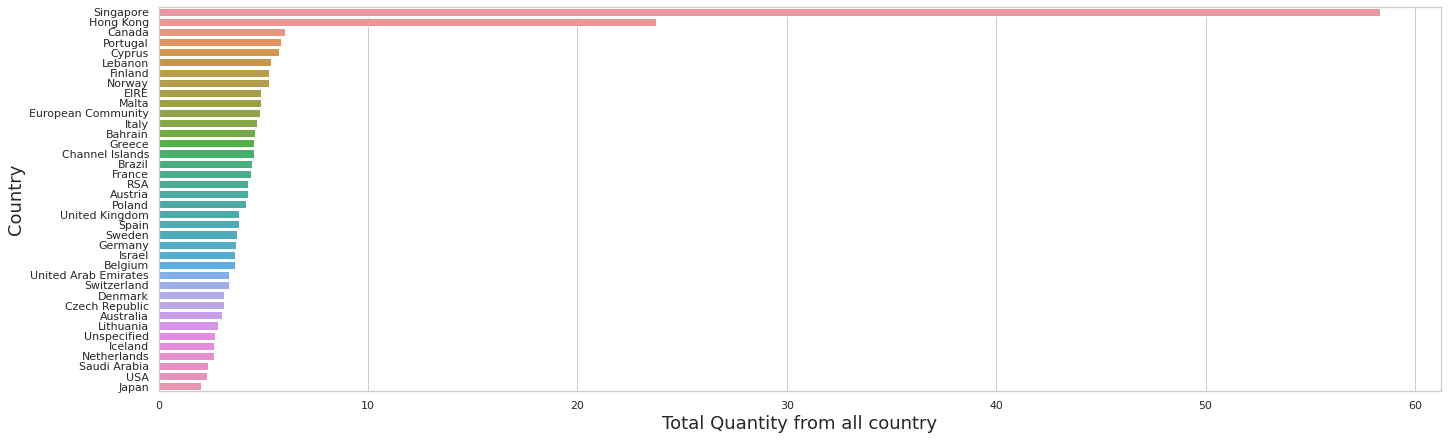

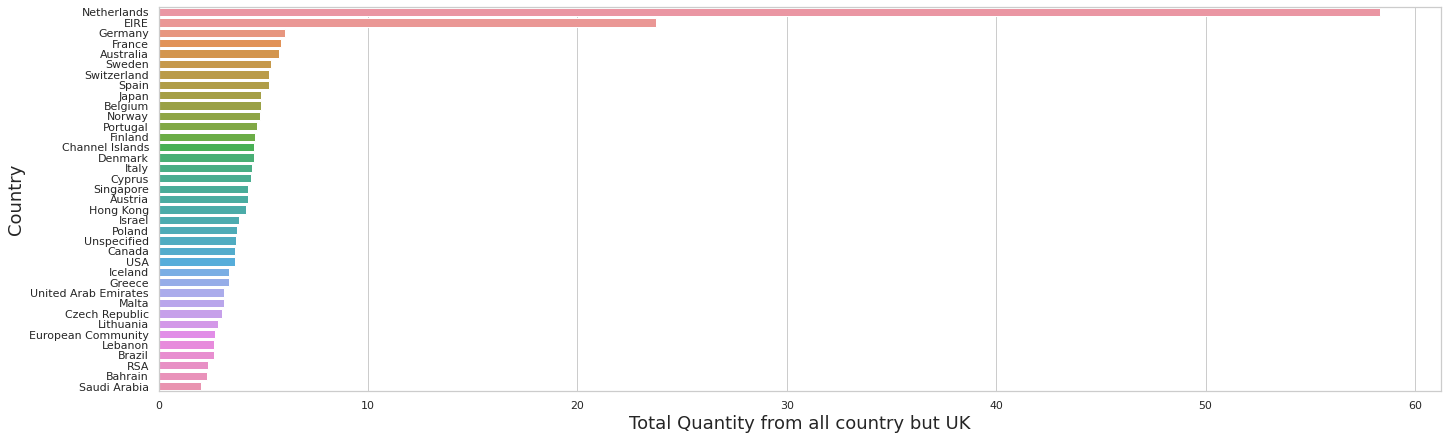

In [ ]:
unitprice_average = df.groupby('Country')[['Price']].agg(['sum',
                                        'mean']).sort_values(by=[('Price', 'mean')], ascending=False)
display(unitprice_average)

fig = plt.figure(constrained_layout=True, figsize=(20, 6))
a = sns.barplot(y=unitprice_average.index, x=unitprice_average[('Price', 'mean')])
plt.xlabel('Total Quantity from all country', fontsize=18)
plt.ylabel('Country', fontsize=18)


fig = plt.figure(constrained_layout=True, figsize=(20, 6))
unitprice_average = unitprice_average.drop('United Kingdom')
sns.barplot(y=country_quantity.index, x=unitprice_average[('Price', 'mean')])
plt.xlabel('Total Quantity from all country but UK', fontsize=18)
plt.ylabel('Country', fontsize=18)
plt.show()


### Question 6: Which month we sell out most and least?
- As we see, from January to  August, the revenue makes a gradual increase from \\$4M to \\$5M.
- Towards the end of the year, sales make a huge jump to over a million and peak in November with \\$10M
- However, looking at average revenue diagram indicates nothing change drastically.

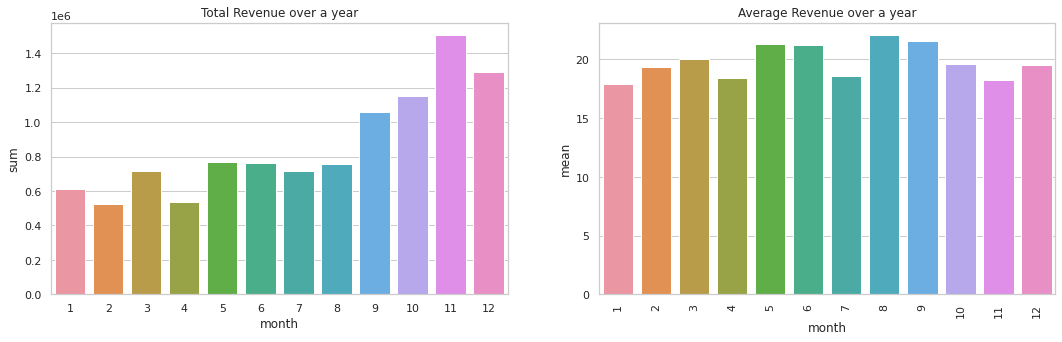

,sum,mean
month,,
1,612628.010,17.913623
2,522545.560,19.347090
3,716215.260,20.037917
4,536968.491,18.425299
5,769296.610,21.274207
6,760547.010,21.185153
7,718076.121,18.611205
8,757841.380,22.033475
9,1056435.192,21.533534


In [ ]:
month_sales = df.groupby(['month'])['Revenue'].agg(['sum','mean'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=month_sales.index, y=month_sales['sum'], ax=axes[0]).set_title("Total Revenue over a year")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=month_sales.index, y=month_sales['mean'], ax=axes[1]).set_title("Average Revenue over a year")
plt.xticks(rotation=90)
plt.show()

month_sales

### Question 7: What time do people tend to buy our products?
- At 6 o'clock, people may want to return undesired stuff
- Starting from 7 am, people tend to make purchase on the online retail. As we can see the revenue hit the top at 12pm. Afterwards, sales gradually decrease till 18pm. After that only a few of customers left make purchases.
- Taking a look at the 2nd image, average revenue for an invoice at 7 am is substantially higher than the rest hours in a day. It suggests people make a huge quantity of items per transaction at the beginning of a day. 

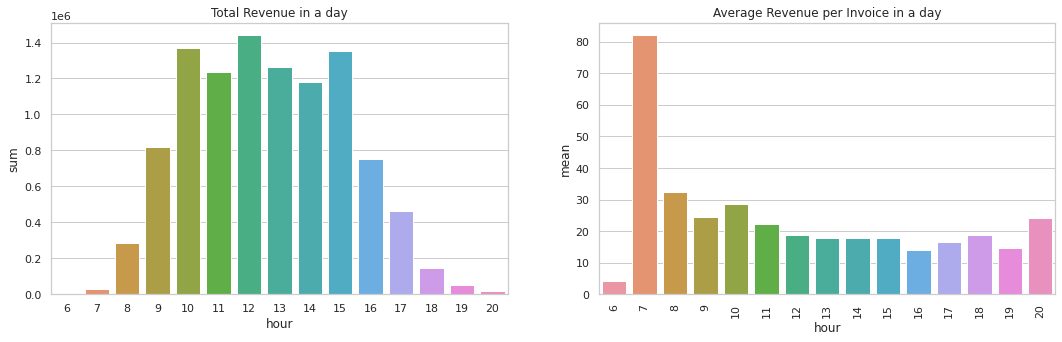

,sum,mean
hour,,
6,4.250,4.250000
7,31059.210,81.950422
8,283750.680,32.229746
9,821585.391,24.315173
10,1367631.171,28.610334
11,1236573.290,22.176311
12,1439342.660,18.879596
13,1261195.200,17.968815
14,1177907.521,17.966315


In [ ]:
hour_sales = df.groupby(['hour'])['Revenue'].agg(['sum','mean'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=hour_sales.index, y=hour_sales['sum'], ax=axes[0]).set_title("Total Revenue in a day")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=hour_sales.index, y=hour_sales['mean'], ax=axes[1]).set_title("Average Revenue per Invoice in a day")
plt.xticks(rotation=90)
plt.show()

hour_sales

### Question 8: Which day of a week people tend to visit and purchase stuff?
- It seems sales goes up and down during week days.
- At the weekend, there is no transaction on Saturday, and sales on Sunday is just as a half or a third as compared to weekdays.
- 2 Images below look the same in distribution

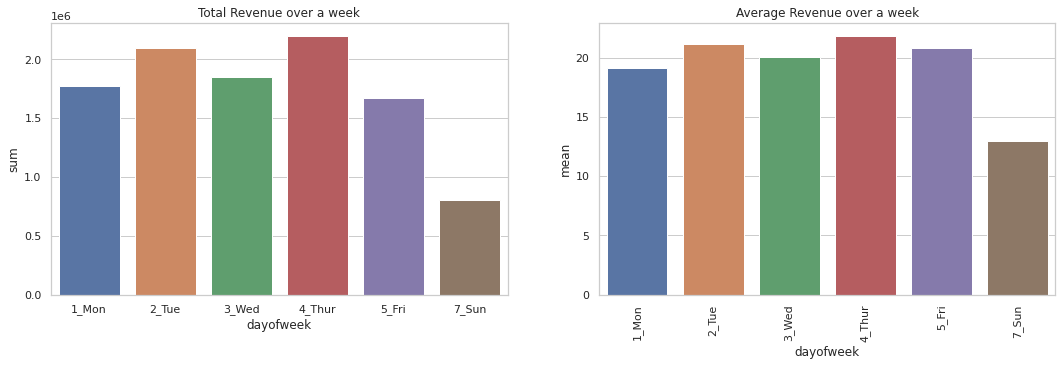

,sum,mean
dayofweek,,
1_Mon,1775782.071,19.131253
2_Tue,2098516.911,21.128633
3_Wed,1847074.380,20.079733
4_Thur,2199292.570,21.838310
5_Fri,1669018.891,20.809153
7_Sun,806790.781,12.940953


In [ ]:
dayofweek_sales = df.groupby(['dayofweek'])['Revenue'].agg(['sum','mean',])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=dayofweek_sales.index, y=dayofweek_sales['sum'], ax=axes[0]).set_title("Total Revenue over a week")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_sales.index, y=dayofweek_sales['mean'], ax=axes[1]).set_title("Average Revenue over a week")
plt.xticks(rotation=90)
plt.show()

dayofweek_sales

### Question 9: Are there any relationship between Repeat Customers and All Customers over a year?
- Investigating the number of Repeat Customers and All Customers
- Looking at the revenue generated from the Repeat Customers and All Customers

In [ ]:
# Get our date range for our data
print('Date Range: %s to %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

# We're taking all of the transactions that occurred before December 01, 2011 
df = df[df['InvoiceDate'] < '2011-12-01']

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
# Get total amount spent per invoice and associate it with CustomerID and Country
invoice_customer_df = df.groupby(by=['Invoice', 'InvoiceDate']).agg({'Revenue': sum,'Customer ID': max,'Country': max,}).reset_index()
invoice_customer_df

,Invoice,InvoiceDate,Revenue,Customer ID,Country
0,536365,2010-12-01 08:26:00,139.12,17850.0,United Kingdom
1,536366,2010-12-01 08:28:00,22.20,17850.0,United Kingdom
2,536367,2010-12-01 08:34:00,278.73,13047.0,United Kingdom
3,536368,2010-12-01 08:34:00,70.05,13047.0,United Kingdom
4,536369,2010-12-01 08:35:00,17.85,13047.0,United Kingdom
...,...,...,...,...,...
21229,579879,2011-11-30 17:13:00,0.00,NaN,United Kingdom
21230,579880,2011-11-30 17:14:00,0.00,NaN,United Kingdom
21231,579881,2011-11-30 17:22:00,905.52,12429.0,Denmark
21232,579885,2011-11-30 17:37:00,1075.36,15444.0,United Kingdom


In [ ]:

# We set our index to our invoice date
# And use Grouper(freq='M') groups data by the index 'InvoiceDate' by Month
# We then group this data by CustomerID and count the number of unique repeat customers for that month (data is the month end date)
# The filter fucntion allows us to subselect data by the rule in our lambda function i.e. those greater than 1 (repeat customers)

monthly_repeat_customers_df = invoice_customer_df.set_index('InvoiceDate').groupby([
              pd.Grouper(freq='M'), 'Customer ID']).filter(lambda x: len(x) > 1).resample('M').nunique()['Customer ID']

monthly_repeat_customers_df

InvoiceDate
2010-12-31    263
2011-01-31    153
2011-02-28    153
2011-03-31    203
2011-04-30    170
2011-05-31    281
2011-06-30    220
2011-07-31    227
2011-08-31    198
2011-09-30    272
2011-10-31    324
2011-11-30    541
Freq: M, Name: Customer ID, dtype: int64

In [ ]:
# Number of Unique customers per month
monthly_unique_customers_df = df.set_index('InvoiceDate')['Customer ID'].resample('M').nunique()
monthly_unique_customers_df

InvoiceDate
2010-12-31     885
2011-01-31     740
2011-02-28     758
2011-03-31     974
2011-04-30     856
2011-05-31    1056
2011-06-30     991
2011-07-31     949
2011-08-31     935
2011-09-30    1266
2011-10-31    1364
2011-11-30    1665
Freq: M, Name: Customer ID, dtype: int64

In [ ]:
# Ratio of Repeat to Unique customers
monthly_repeat_percentage = monthly_repeat_customers_df/monthly_unique_customers_df*100.0
monthly_repeat_percentage

InvoiceDate
2010-12-31    29.717514
2011-01-31    20.675676
2011-02-28    20.184697
2011-03-31    20.841889
2011-04-30    19.859813
2011-05-31    26.609848
2011-06-30    22.199798
2011-07-31    23.919916
2011-08-31    21.176471
2011-09-30    21.484992
2011-10-31    23.753666
2011-11-30    32.492492
Freq: M, Name: Customer ID, dtype: float64

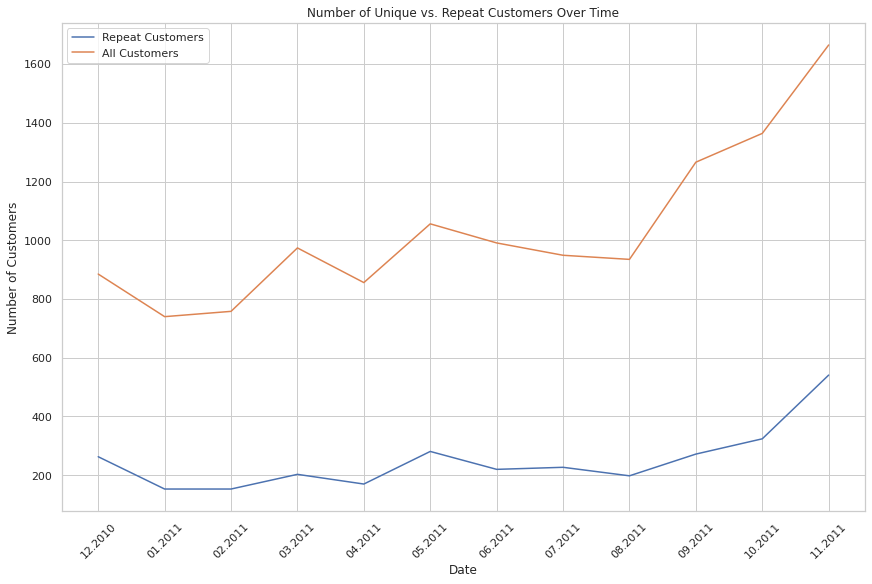

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 6))
grid = gridspec.GridSpec(nrows=1, ncols=1,  figure=fig)

ax = fig.add_subplot(grid[0, 0])

pd.DataFrame(monthly_repeat_customers_df.values).plot(ax=ax, figsize=(12,8))

pd.DataFrame(monthly_unique_customers_df.values).plot(ax=ax,grid=True)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Unique vs. Repeat Customers Over Time')
plt.xticks(range(len(monthly_repeat_customers_df.index)), [x.strftime('%m.%Y') for x in monthly_repeat_customers_df.index], rotation=45)
ax.legend(['Repeat Customers', 'All Customers'])

In [ ]:
# Let's investigate the relationship between revenue and repeat customers
monthly_revenue_df = df.set_index('InvoiceDate')['Revenue'].resample('M').sum()

monthly_rev_repeat_customers_df = invoice_customer_df.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'Customer ID']).filter(lambda x: len(x) > 1).resample('M').sum()['Revenue']

# Let's get a percentage of the revenue from repeat customers to the overall monthly revenue
monthly_rev_perc_repeat_customers_df = monthly_rev_repeat_customers_df/monthly_revenue_df * 100.0
monthly_rev_perc_repeat_customers_df

InvoiceDate
2010-12-31    43.592279
2011-01-31    36.192965
2011-02-28    36.529134
2011-03-31    37.271656
2011-04-30    36.341918
2011-05-31    49.118953
2011-06-30    49.398260
2011-07-31    44.148370
2011-08-31    41.758878
2011-09-30    47.303884
2011-10-31    49.728404
2011-11-30    47.276412
Freq: M, Name: Revenue, dtype: float64

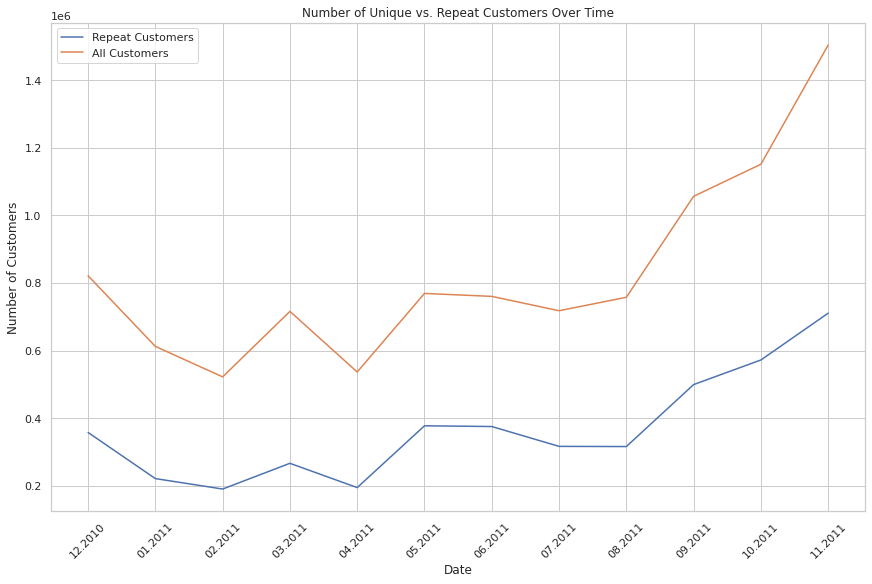

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 6))
grid = gridspec.GridSpec(nrows=1, ncols=1,  figure=fig)

ax = fig.add_subplot(grid[0, 0])
pd.DataFrame(monthly_rev_repeat_customers_df.values).plot(ax=ax, figsize=(12,8))

pd.DataFrame(monthly_revenue_df.values).plot(ax=ax,grid=True)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Unique vs. Repeat Customers Over Time')
plt.xticks(range(len(monthly_repeat_customers_df.index)), [x.strftime('%m.%Y') for x in monthly_repeat_customers_df.index], rotation=45)
ax.legend(['Repeat Customers', 'All Customers'])

### Question 10: What are the item trends?

Let's count the number of items sold for each product for each period.

In [ ]:
# Now let's get quantity of each item sold per month
date_item_df = df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'), 'StockCode'])['Quantity'].sum()
date_item_df.head(15)

InvoiceDate  StockCode
2010-12-31   10002         251
             10120          16
             10125         154
             10133         130
             10135         411
             11001          74
             15034          45
             15036         161
             15039          20
             16008          14
             16010          12
             16011          94
             16012         120
             16014        1029
             16015          21
Name: Quantity, dtype: int64

In [ ]:
# Rank items by the last month's sales
last_month_sorted_df = date_item_df.loc['2011-11-30']
last_month_sorted_df = last_month_sorted_df.reset_index()
last_month_sorted_df.sort_values(by='Quantity', ascending=False).head(10)

,InvoiceDate,StockCode,Quantity
1576,2011-11-30,23084,14913
2243,2011-11-30,84826,12551
814,2011-11-30,22197,12452
722,2011-11-30,22086,7898
2719,2011-11-30,85099B,5908
1127,2011-11-30,22578,5365
2249,2011-11-30,84879,5219
1126,2011-11-30,22577,5001
2727,2011-11-30,85123A,4652
2199,2011-11-30,84077,4559


In [ ]:
# Let's look at the top 5 items sale over a year
date_item_df = df.loc[df['StockCode'].isin(['23084', '84826', '22197', '22086', '85099B'])].set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'StockCode','Description'])['Quantity'].sum().reset_index()

date_item_df

,InvoiceDate,StockCode,Description,Quantity
0,2010-12-31,85099B,JUMBO BAG RED RETROSPOT,2152
1,2011-01-31,85099B,JUMBO BAG RED RETROSPOT,2747
2,2011-02-28,85099B,JUMBO BAG RED RETROSPOT,3080
3,2011-03-31,85099B,JUMBO BAG RED RETROSPOT,5282
4,2011-04-30,85099B,JUMBO BAG RED RETROSPOT,2456
5,2011-05-31,85099B,JUMBO BAG RED RETROSPOT,3621
6,2011-06-30,85099B,JUMBO BAG RED RETROSPOT,3682
7,2011-07-31,85099B,JUMBO BAG RED RETROSPOT,3129
8,2011-08-31,85099B,JUMBO BAG RED RETROSPOT,5402
9,2011-09-30,85099B,JUMBO BAG RED RETROSPOT,4399


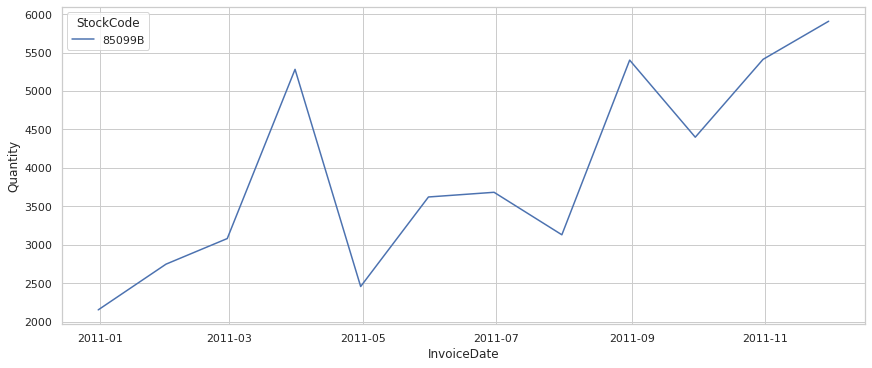

In [ ]:
date_item_df = date_item_df.reset_index()

sns.set(style='whitegrid')
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.lineplot(x=date_item_df['InvoiceDate'], y=date_item_df['Quantity'], hue=date_item_df['StockCode'])

### Question 11: Top 10 Reorder Items

In [ ]:
df.groupby(['StockCode', 'Description'])['Invoice'].count().sort_values(ascending = False).head(10)

StockCode  Description                       
85123A     WHITE HANGING HEART T-LIGHT HOLDER    2190
85099B     JUMBO BAG RED RETROSPOT               2058
22423      REGENCY CAKESTAND 3 TIER              1948
47566      PARTY BUNTING                         1672
20725      LUNCH BAG RED RETROSPOT               1537
84879      ASSORTED COLOUR BIRD ORNAMENT         1429
22720      SET OF 3 CAKE TINS PANTRY DESIGN      1354
21212      PACK OF 72 RETROSPOT CAKE CASES       1315
20727      LUNCH BAG  BLACK SKULL.               1254
22386      JUMBO BAG PINK POLKADOT               1210
Name: Invoice, dtype: int64

### Question 12: What is the Mall's Cancellation Rate?

In [ ]:
Num_Canceled_Orders = df[df['Quantity']<0]['Invoice'].nunique()
Total_Orders = df['Invoice'].nunique()
print('Cancellation Rate: {:.2f}%'.format(Num_Canceled_Orders/Total_Orders*100 ))

Cancellation Rate: 6.19%


### Question 13: The revenue comes from repeat items or 1 items per month?

In [ ]:
Monthly_Reorder_Items_Revenue = df.set_index('InvoiceDate').groupby([ pd.Grouper(freq='M'), 'StockCode']).filter(lambda x: len(x) > 1).resample('M').sum()['Revenue']
Monthly_One_Items_Revenue = df.set_index('InvoiceDate').groupby([ pd.Grouper(freq='M'), 'StockCode']).filter(lambda x: len(x) == 1).resample('M').sum()['Revenue']
#Monthly_Revenue = df.groupby(['year','month']).sum()['Revenue']  # Generate the same Result
Monthly_Revenue = df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M')]).sum()['Revenue']

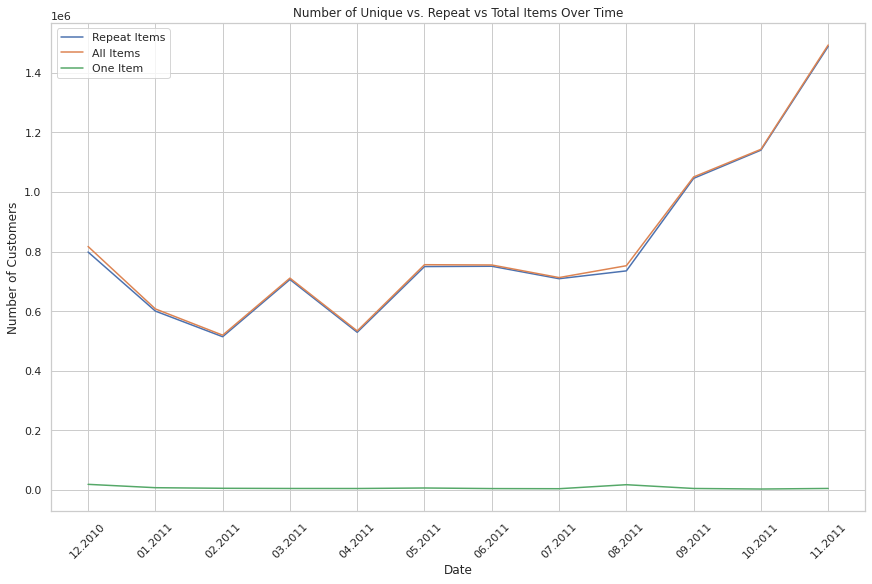

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 6))

ax = fig.add_subplot()
pd.DataFrame(Monthly_Reorder_Items_Revenue.values).plot(ax=ax, figsize=(12,8))
pd.DataFrame(Monthly_Revenue.values).plot(ax=ax,grid=True)
pd.DataFrame(Monthly_One_Items_Revenue.values).plot(ax=ax,grid=True)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Unique vs. Repeat vs Total Items Over Time')
plt.xticks(range(len(monthly_repeat_customers_df.index)), [x.strftime('%m.%Y') for x in monthly_repeat_customers_df.index], rotation=45)
ax.legend(['Repeat Items', 'All Items', 'One Item'])

# Preparing Invoice-Product Matrix fot ARL Data Structure

In [ ]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
df_germany = df[df["Country"] == "Germany"]
df_germany.shape

(8353, 15)

In [ ]:
gr_inv_pro_df = create_invoice_product_df(df_germany, id=True)
gr_inv_pro_df.head()

StockCode,10002,10125,10135,11001,15034,15036,15039,16008,16011,16014,...,90160D,90161B,90161C,90161D,90201A,90201B,90201C,90201D,90202D,M
Invoice,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's define a function to find the product name corresponding to the stock code:

def check_id(dataframe, stockcode):
    product_name = dataframe[dataframe["StockCode"] == stockcode]["Description"].unique()[0]
    return stockcode, product_name

In [ ]:
check_id(df_germany, 10002)

(10002, 'INFLATABLE POLITICAL GLOBE')

In [ ]:
check_id(df_germany, 47480)

(47480, 'HANGING PHOTO CLIP ROPE LADDER')

In [ ]:
check_id(df_germany, 22977)

(22977, 'DOLLY GIRL CHILDRENS EGG CUP')

# Determination of Association Rules

Calculate the support values for every possible configuration of items (thereshold of support has been chosen 0.01 (1%))

In [ ]:
frequent_itemsets = apriori(gr_inv_pro_df, min_support=0.01, use_colnames=True)

In [ ]:
frequent_itemsets.head()

,support,itemsets
0,0.011574,(10125)
1,0.020833,(15036)
2,0.011574,(16016)
3,0.016204,(16045)
4,0.011574,(16235)


In [ ]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)

rules.sort_values("support", ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2052,(22328),(22326),0.157407,0.247685,0.129630,0.823529,3.324904,0.090642,4.263117
2053,(22326),(22328),0.247685,0.157407,0.129630,0.523364,3.324904,0.090642,1.767792
2102,(22554),(22326),0.136574,0.247685,0.074074,0.542373,2.189767,0.040247,1.643947
2103,(22326),(22554),0.247685,0.136574,0.074074,0.299065,2.189767,0.040247,1.231821
2118,(22629),(22326),0.104167,0.247685,0.071759,0.688889,2.781308,0.045959,2.418155


Let's sort dataframe by lift:

In [ ]:
sorted_rules = rules.sort_values("lift", ascending=False)

# Suggesting a Product to Users at the Basket Stage

In [ ]:
product_id = 22492

check_id(df, product_id)

(22492, 'MINI PAINT SET VINTAGE')

First, define a function for recommending a product:

In [ ]:
product_id = 22554
recommendation_list = []


for idx, product in enumerate(sorted_rules["antecedents"]):
    
    for j in list(product):
        if j == product_id:
            
            recommendation_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
            recommendation_list = list( dict.fromkeys(recommendation_list) )

Let's bring the top 5 most preferred products together with the product with id 22492.

In [ ]:
list_top5 = recommendation_list[0:5]
list_top5

[21086, 21094, 21672, 21668, 21670]

In [ ]:
# Let's show the product names of top 5 recommended products:

for elem in list_top5:
    print(check_id(df_germany,elem))

(21086, 'SET/6 RED SPOTTY PAPER CUPS')
(21094, 'SET/6 RED SPOTTY PAPER PLATES')
(21672, 'WHITE SPOT RED CERAMIC DRAWER KNOB')
(21668, 'RED STRIPE CERAMIC DRAWER KNOB')
(21670, 'BLUE SPOT CERAMIC DRAWER KNOB')


# MARKET BASKET ANALYSIS
- The solution focus on improving marketing performance upon data driven.
- Applying Association Rule with Apriori Algorithm to extract frequent itemsets in data mining.
- Final thought: Apriori is very useful for finding simple associations between our data items. They are easy to implement and have high explain-ability.

In [ ]:
# Import & Filter Data:

def data_filter(dataframe, country=False, Country=""):
    if country:
        dataframe = dataframe[dataframe["Country"] == Country]
    return dataframe

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
def data_prep(dataframe):
    
    # Data preprocessing:
    dataframe.dropna(inplace=True)
    
    # Delete if the product name contains "POST":
    dataframe = dataframe[~dataframe["StockCode"].str.contains("POST", na=False)]
    
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe

In [ ]:
# Invoice Product Matrix:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0) 

In [ ]:
# Find Product name with Stock Code:

def check_id(dataframe, stockcode):
    product_name = dataframe[dataframe["StockCode"] == stockcode]["Description"].unique()[0]
    return stockcode, product_name


In [ ]:
# Apriori Algorithm & ARL Rules:

def apriori_alg(dataframe, support_val=0.01):
    inv_pro_df = create_invoice_product_df(dataframe, id=True)
    frequent_itemsets = apriori(inv_pro_df, min_support=support_val, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=support_val)
    sorted_rules =  rules.sort_values("support", ascending=False) 
    return sorted_rules
    
    
  
         
def recommend_product(dataframe, product_id, support_val= 0.01, num_of_products=5):
    sorted_rules = apriori_alg(dataframe, support_val)
    recommendation_list = []  
    for idx, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
                recommendation_list = list( dict.fromkeys(recommendation_list) )
    return(recommendation_list[0:num_of_products])

In [ ]:
# Data Preparation: 
df = df_.copy()

df = data_prep(df)
df = data_filter(df,country=True,Country="Germany")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6.0,2010-12-01 13:04:00,2.95,12662.0,Germany
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6.0,2010-12-01 13:04:00,2.55,12662.0,Germany
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12.0,2010-12-01 13:04:00,0.85,12662.0,Germany
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12.0,2010-12-01 13:04:00,1.65,12662.0,Germany
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12.0,2010-12-01 13:04:00,1.95,12662.0,Germany


In [ ]:
def recommendation_system_func(dataframe,support_val=0.01, num_of_products= 5 ):
    product_id = input("Enter a product id:")
    
    if product_id in list(dataframe["StockCode"].astype("str").unique()):
        product_list = recommend_product(dataframe, int(product_id), support_val, num_of_products)
        if len(product_list) == 0:
            print("There is no product can be recommended!")
        else:
            print("Related products with product id -" , product_id , "can be seen below:")
        
            for i in range(0, len(product_list[0:num_of_products])):
                print(check_id(dataframe, product_list[i]))
            
    else:
        print("Invalid Product Id, try again!")

In [ ]:
# Enter product id - 1 (22326)

recommendation_system_func(df)

Enter a product id:22326
Related products with product id - 22326 can be seen below:
(22328, 'ROUND SNACK BOXES SET OF 4 FRUITS ')
(22554, 'PLASTERS IN TIN WOODLAND ANIMALS')
(22629, 'SPACEBOY LUNCH BOX ')
(20719, 'WOODLAND CHARLOTTE BAG')
(22556, 'PLASTERS IN TIN CIRCUS PARADE ')


In [ ]:
# Enter product id - 2 (22725)

recommendation_system_func(df)

Enter a product id:22725
Related products with product id - 22725 can be seen below:
(22727, 'ALARM CLOCK BAKELIKE RED ')
(22326, 'ROUND SNACK BOXES SET OF4 WOODLAND ')
(22728, 'ALARM CLOCK BAKELIKE PINK')
(22726, 'ALARM CLOCK BAKELIKE GREEN')
(22729, 'ALARM CLOCK BAKELIKE ORANGE')


In [ ]:
# Enter product id - 3 (22809)

recommendation_system_func(df)

Enter a product id:22809
There is no product can be recommended!


In [ ]:
# Enter product id - 4 (2256523)

recommendation_system_func(df)

Enter a product id:2256523
Invalid Product Id, try again!


# MODELING
- RandomForest Regression

### RandomForest Regression
#### Observation:
- Apply 6 new features such as NumberOrders, Unitprice, days_as_customer, days_since_purchase, NumberItems, OrderFrequency to regression model to predict which features have most influence on Revenue the company receive, then accordingly running marketing campaigns to yeild highest profit. 
- The diagram below indicates NumberOrders and UnitPrice are 2 most important factors of forming revenue.
- As we already discuss above, having higher price may have traded off against NumberOrders, thus the next step for the company is to run the A/B Test to know if we should increase UnitPrice followed by a deduction of NumberOrder and vice versa.
- days-as-customers and days-since-purcharse may not contribute much to see if a customer is loyal and bring most revenue to us. 

In [ ]:
# df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format="%m/%d/%Y %H:%M")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Revenue'] = df['Quantity']*df['Price']

In [ ]:
invoice_ct = df.groupby(by='Customer ID', as_index=False)['Invoice'].count()
invoice_ct.columns = ['Customer ID', 'NumberOrders']
invoice_ct

,Customer ID,NumberOrders
0,12426.0,29
1,12427.0,28
2,12468.0,36
3,12471.0,440
4,12472.0,332
...,...,...
89,13814.0,57
90,13815.0,173
91,13816.0,26
92,13817.0,22


In [ ]:
unitprice = df.groupby(by='Customer ID', as_index=False)['Price'].mean()
unitprice.columns = ['Customer ID', 'price']
unitprice

,Customer ID,price
0,12426.0,3.451379
1,12427.0,3.152143
2,12468.0,2.710278
3,12471.0,2.668568
4,12472.0,2.068705
...,...,...
89,13814.0,3.020702
90,13815.0,2.299249
91,13816.0,3.399615
92,13817.0,1.875909


In [ ]:
revenue = df.groupby(by='Customer ID', as_index=False)['Revenue'].sum()
revenue.columns = ['Customer ID', 'Revenue']
revenue

,Customer ID,Revenue
0,12426.0,510.73
1,12427.0,699.80
2,12468.0,657.54
3,12471.0,17454.05
4,12472.0,6068.11
...,...,...
89,13814.0,1579.12
90,13815.0,3667.36
91,13816.0,491.28
92,13817.0,328.98


In [ ]:
total_items = df.groupby(by='Customer ID', as_index=False)['Quantity'].sum()
total_items.columns = ['Customer ID', 'NumberItems']
total_items

,Customer ID,NumberItems
0,12426.0,254.0
1,12427.0,526.0
2,12468.0,362.0
3,12471.0,8105.0
4,12472.0,4120.0
...,...,...
89,13814.0,864.0
90,13815.0,2540.0
91,13816.0,265.0
92,13817.0,208.0


In [ ]:
earliest_order = df.groupby(by='Customer ID', as_index=False)['InvoiceDate'].min()
earliest_order

,Customer ID,InvoiceDate
0,12426.0,2011-05-29 12:26:00
1,12427.0,2010-12-03 10:44:00
2,12468.0,2011-01-27 13:29:00
3,12471.0,2010-12-10 09:35:00
4,12472.0,2010-12-05 14:19:00
...,...,...
89,13814.0,2011-07-25 13:54:00
90,13815.0,2011-01-25 12:16:00
91,13816.0,2011-10-06 14:37:00
92,13817.0,2010-12-23 11:46:00


In [ ]:
earliest_order.columns = ['Customer ID', 'EarliestInvoice']

In [ ]:
earliest_order['now'] = pd.to_datetime((df['InvoiceDate']).max())

In [ ]:
earliest_order

,Customer ID,EarliestInvoice,now
0,12426.0,2011-05-29 12:26:00,2011-12-09 12:16:00
1,12427.0,2010-12-03 10:44:00,2011-12-09 12:16:00
2,12468.0,2011-01-27 13:29:00,2011-12-09 12:16:00
3,12471.0,2010-12-10 09:35:00,2011-12-09 12:16:00
4,12472.0,2010-12-05 14:19:00,2011-12-09 12:16:00
...,...,...,...
89,13814.0,2011-07-25 13:54:00,2011-12-09 12:16:00
90,13815.0,2011-01-25 12:16:00,2011-12-09 12:16:00
91,13816.0,2011-10-06 14:37:00,2011-12-09 12:16:00
92,13817.0,2010-12-23 11:46:00,2011-12-09 12:16:00


In [ ]:
# == earliest_order['days_as_customer'] = 1 + (earliest_order.now-earliest_order.EarliestInvoice).dt.days
# Source: https://kite.com/python/docs/pandas.core.indexes.accessors.TimedeltaProperties
earliest_order['days_as_customer'] = 1 + (earliest_order['now']-earliest_order['EarliestInvoice']).dt.days

In [ ]:
earliest_order.drop('now', axis=1, inplace=True)
earliest_order

,Customer ID,EarliestInvoice,days_as_customer
0,12426.0,2011-05-29 12:26:00,194
1,12427.0,2010-12-03 10:44:00,372
2,12468.0,2011-01-27 13:29:00,316
3,12471.0,2010-12-10 09:35:00,365
4,12472.0,2010-12-05 14:19:00,369
...,...,...,...
89,13814.0,2011-07-25 13:54:00,137
90,13815.0,2011-01-25 12:16:00,319
91,13816.0,2011-10-06 14:37:00,64
92,13817.0,2010-12-23 11:46:00,352


In [ ]:
# when was their last order and how long ago was that from the last date in file (presumably
# when the data were pulled)
last_order = df.groupby(by='Customer ID', as_index=False)['InvoiceDate'].max()
last_order.columns = ['Customer ID', 'last_purchase']
last_order['now'] = pd.to_datetime((df['InvoiceDate']).max())
last_order['days_since_last_purchase'] = 1 + (last_order.now-last_order.last_purchase).astype('timedelta64[D]')
last_order.drop('now', axis=1, inplace=True)
last_order

,Customer ID,last_purchase,days_since_last_purchase
0,12426.0,2011-05-29 12:26:00,194.0
1,12427.0,2011-11-18 08:56:00,22.0
2,12468.0,2011-06-05 11:36:00,188.0
3,12471.0,2011-12-07 15:43:00,2.0
4,12472.0,2011-11-07 14:01:00,32.0
...,...,...,...
89,13814.0,2011-09-08 13:48:00,92.0
90,13815.0,2011-11-17 14:19:00,22.0
91,13816.0,2011-11-16 08:38:00,24.0
92,13817.0,2011-11-10 17:49:00,29.0


In [ ]:
#combine all the dataframes into one
import functools
dfs = [invoice_ct,unitprice,revenue,earliest_order,last_order,total_items]
CustomerTable = functools.reduce(lambda left,right: pd.merge(left,right,on='Customer ID', how='outer'), dfs)
CustomerTable['OrderFrequency'] = CustomerTable['NumberOrders']/CustomerTable['days_as_customer']
CustomerTable

,Customer ID,NumberOrders,price,Revenue,EarliestInvoice,days_as_customer,last_purchase,days_since_last_purchase,NumberItems,OrderFrequency
0,12426.0,29,3.451379,510.73,2011-05-29 12:26:00,194,2011-05-29 12:26:00,194.0,254.0,0.149485
1,12427.0,28,3.152143,699.80,2010-12-03 10:44:00,372,2011-11-18 08:56:00,22.0,526.0,0.075269
2,12468.0,36,2.710278,657.54,2011-01-27 13:29:00,316,2011-06-05 11:36:00,188.0,362.0,0.113924
3,12471.0,440,2.668568,17454.05,2010-12-10 09:35:00,365,2011-12-07 15:43:00,2.0,8105.0,1.205479
4,12472.0,332,2.068705,6068.11,2010-12-05 14:19:00,369,2011-11-07 14:01:00,32.0,4120.0,0.899729
...,...,...,...,...,...,...,...,...,...,...
89,13814.0,57,3.020702,1579.12,2011-07-25 13:54:00,137,2011-09-08 13:48:00,92.0,864.0,0.416058
90,13815.0,173,2.299249,3667.36,2011-01-25 12:16:00,319,2011-11-17 14:19:00,22.0,2540.0,0.542320
91,13816.0,26,3.399615,491.28,2011-10-06 14:37:00,64,2011-11-16 08:38:00,24.0,265.0,0.406250
92,13817.0,22,1.875909,328.98,2010-12-23 11:46:00,352,2011-11-10 17:49:00,29.0,208.0,0.062500


In [ ]:
CustomerTable.corr()['Revenue'].sort_values(ascending = False)

Revenue                     1.000000
NumberItems                 0.928686
NumberOrders                0.842576
days_as_customer            0.441037
OrderFrequency             -0.001835
price                      -0.038067
Customer ID                -0.141722
days_since_last_purchase   -0.273425
Name: Revenue, dtype: float64

In [ ]:
x = CustomerTable[['NumberOrders','price', 'days_as_customer', 'days_since_last_purchase', 'NumberItems', 'OrderFrequency']]
y = CustomerTable['Revenue']

#### Observation:
- NumberOrders and Price are 2 most important factors of forming revenue.
- days-as-customers and days-since-purcharse may not contribute much to see if a customer is loyal and bring most revenue to us.

Text(0.5, 1.0, 'Feature importance using Linear Model')

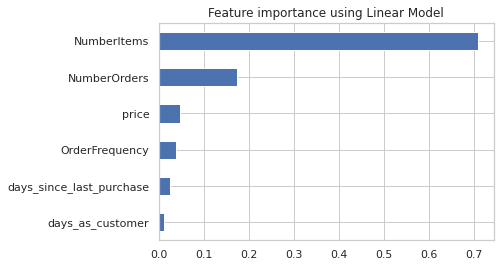

In [ ]:
reg = RandomForestRegressor()
reg.fit(x.values, y)

#list(zip(x, reg.feature_importances_))
coef = pd.Series(reg.feature_importances_, index = x.columns)

imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Model")

# RFM - Recency Frequency Monetary 

In [ ]:
recency = df.groupby(by='Customer ID', as_index=False)['InvoiceDate'].max()
recency.columns = ['Customer ID', 'last_purchase']
recency['now'] = pd.to_datetime((df['InvoiceDate']).max())
recency['Recency'] = 1 + (recency.now-recency['last_purchase']).astype('timedelta64[D]')
recency.drop(['now','last_purchase'], axis=1, inplace=True)
recency.head()

,Customer ID,Recency
0,12426.0,194.0
1,12427.0,22.0
2,12468.0,188.0
3,12471.0,2.0
4,12472.0,32.0


In [ ]:
#check frequency of customer means how many transaction has been done..

frequency = df.copy()
frequency.drop_duplicates(subset=['Customer ID','Invoice'], keep="first", inplace=True) 
frequency = frequency.groupby('Customer ID',as_index=False)['Invoice'].count()
frequency.columns = ['Customer ID','Frequency']
frequency.head()

,Customer ID,Frequency
0,12426.0,1
1,12427.0,3
2,12468.0,2
3,12471.0,28
4,12472.0,7


In [ ]:
monetary=df.groupby('Customer ID',as_index=False)['Revenue'].sum()
monetary.columns = ['Customer ID','Monetary']
monetary.head()

,Customer ID,Monetary
0,12426.0,510.73
1,12427.0,699.80
2,12468.0,657.54
3,12471.0,17454.05
4,12472.0,6068.11


In [ ]:
dfs = [recency, frequency, monetary]
rfm = functools.reduce(lambda left,right: pd.merge(left,right,on='Customer ID', how='outer'), dfs)

In [ ]:
rfm

,Customer ID,Recency,Frequency,Monetary
0,12426.0,194.0,1,510.73
1,12427.0,22.0,3,699.80
2,12468.0,188.0,2,657.54
3,12471.0,2.0,28,17454.05
4,12472.0,32.0,7,6068.11
...,...,...,...,...
89,13814.0,92.0,2,1579.12
90,13815.0,22.0,4,3667.36
91,13816.0,24.0,2,491.28
92,13817.0,29.0,2,328.98


In [ ]:
#bring all the quartile value in a single dataframe
rfm_segmentation = rfm.copy()

In [ ]:
rfm_segmentation

,Customer ID,Recency,Frequency,Monetary
0,12426.0,194.0,1,510.73
1,12427.0,22.0,3,699.80
2,12468.0,188.0,2,657.54
3,12471.0,2.0,28,17454.05
4,12472.0,32.0,7,6068.11
...,...,...,...,...
89,13814.0,92.0,2,1579.12
90,13815.0,22.0,4,3667.36
91,13816.0,24.0,2,491.28
92,13817.0,29.0,2,328.98


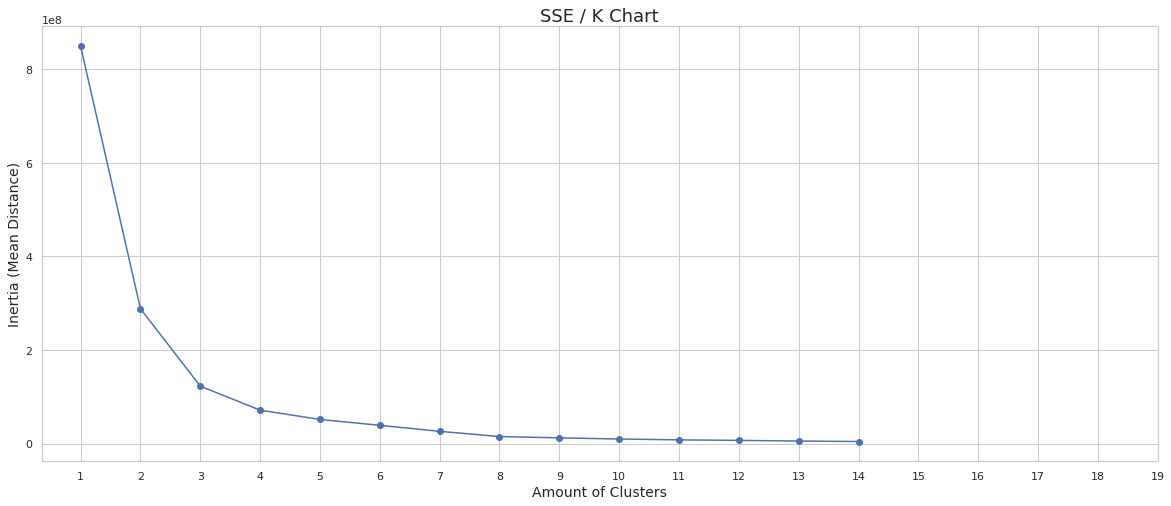

In [ ]:
from sklearn.cluster import KMeans
SSE_to_nearest_centroid = []

for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_segmentation)
    SSE_to_nearest_centroid.append(kmeans.inertia_)

plt.figure(figsize=(20,8))
plt.plot(range(1,15),SSE_to_nearest_centroid,"-o")
plt.title("SSE / K Chart", fontsize=18)
plt.xlabel("Amount of Clusters",fontsize=14)
plt.ylabel("Inertia (Mean Distance)",fontsize=14)
plt.xticks(range(1,20))
plt.grid(True)
plt.show()

In [ ]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

# this creates a new column called cluster which has cluster number for each row respectively.
rfm_segmentation['cluster'] = kmeans.labels_
rfm_segmentation.head()

,Customer ID,Recency,Frequency,Monetary,cluster
0,12426.0,194.0,1,510.73,0
1,12427.0,22.0,3,699.80,0
2,12468.0,188.0,2,657.54,0
3,12471.0,2.0,28,17454.05,1
4,12472.0,32.0,7,6068.11,2


#### Observation
- Recency graph: cluster 0 have high recency rate which is bad, yet cluster 1 and cluster 2 having low so they are in race of platinum and gold customer.
- Frequency graph: cluster 1 and cluster 2 having low so they are in race of platinum and gold customer regarding frequency metrics.
- Monetary graph: cluster 1 have highest Montary (money spend) platinum where as cluster 2 have medium level(Gold) and cluster 0 is silver customer.

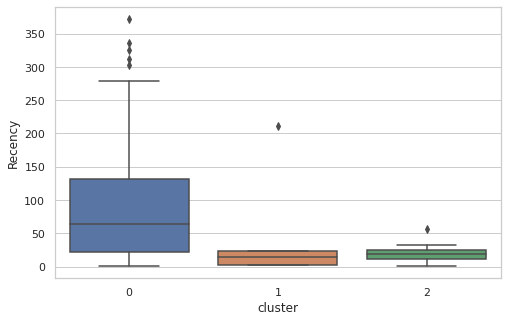

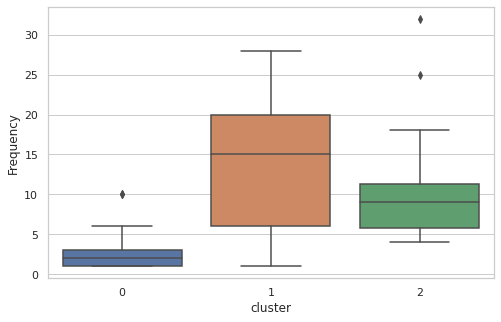

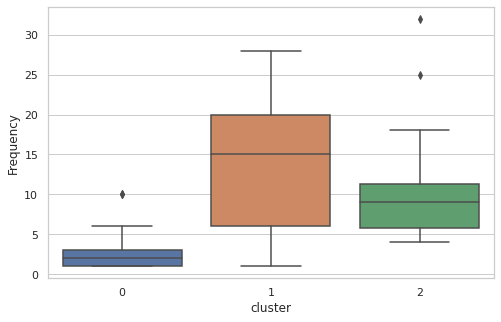

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(rfm_segmentation['cluster'],rfm_segmentation.Recency)

plt.figure(figsize=(8,5))
sns.boxplot(rfm_segmentation['cluster'],rfm_segmentation.Frequency)

plt.figure(figsize=(8,5))
sns.boxplot(rfm_segmentation['cluster'],rfm_segmentation.Frequency)

### More granularity level of analysis

In [ ]:
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile

,Customer ID,Recency,Frequency,Monetary
0.25,12520.25,16.25,1.0,478.10
0.50,12606.00,31.00,3.0,932.76
0.75,12664.25,92.00,5.0,2844.84


In [ ]:
# lower the recency, good for store..
def RScore(x):
    if x <= quantile['Recency'][0.25]:
        return 1
    elif x <= quantile['Recency'][0.50]:
        return 2
    elif x <= quantile['Recency'][0.75]: 
        return 3
    else:
        return 4

# higher value of frequency and monetary lead to a good consumer.
def FScore(x):
    if x <= quantile['Frequency'][0.25]:
        return 4
    elif x <= quantile['Frequency'][0.50]:
        return 3
    elif x <= quantile['Frequency'][0.75]: 
        return 2
    else:
        return 1

def MScore(x):
    if x <= quantile['Monetary'][0.25]:
        return 4
    elif x <= quantile['Monetary'][0.50]:
        return 3
    elif x <= quantile['Monetary'][0.75]: 
        return 2
    else:
        return 1

In [ ]:
rfm_segmentation

,Customer ID,Recency,Frequency,Monetary,cluster
0,12426.0,194.0,1,510.73,0
1,12427.0,22.0,3,699.80,0
2,12468.0,188.0,2,657.54,0
3,12471.0,2.0,28,17454.05,1
4,12472.0,32.0,7,6068.11,2
...,...,...,...,...,...
89,13814.0,92.0,2,1579.12,0
90,13815.0,22.0,4,3667.36,2
91,13816.0,24.0,2,491.28,0
92,13817.0,29.0,2,328.98,0


In [ ]:
rfm_segmentation['R_quartile'] = rfm_segmentation['Recency'].apply(RScore)
rfm_segmentation['F_quartile'] = rfm_segmentation['Frequency'].apply(FScore)
rfm_segmentation['M_quartile'] = rfm_segmentation['Monetary'].apply(MScore)

In [ ]:
rfm_segmentation

,Customer ID,Recency,Frequency,Monetary,cluster,R_quartile,F_quartile,M_quartile
0,12426.0,194.0,1,510.73,0,4,4,3
1,12427.0,22.0,3,699.80,0,2,3,3
2,12468.0,188.0,2,657.54,0,4,3,3
3,12471.0,2.0,28,17454.05,1,1,1,1
4,12472.0,32.0,7,6068.11,2,3,1,1
...,...,...,...,...,...,...,...,...
89,13814.0,92.0,2,1579.12,0,3,3,2
90,13815.0,22.0,4,3667.36,2,2,2,1
91,13816.0,24.0,2,491.28,0,2,3,3
92,13817.0,29.0,2,328.98,0,2,3,4


In [ ]:
# Approach 1: group customer's attributes, leading to detail customer's profile
# for example 121 and 112 are different.
rfm_segmentation['RFMScore'] = rfm_segmentation['R_quartile'].astype(str) \
                               + rfm_segmentation['F_quartile'].astype(str) \
                               + rfm_segmentation['M_quartile'].astype(str)

In [ ]:
# Approach 2: group customer's attributes, leading to more general customers' profile
# for example 121 and 112 are the same.
rfm_segmentation['TotalScore'] = rfm_segmentation['R_quartile'] \
                               + rfm_segmentation['F_quartile'] \
                               + rfm_segmentation['M_quartile']

In [ ]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='134']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='344']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Image(url= "https://i.imgur.com/YmItbbm.png?")

Best Customers:  11
Loyal Customers:  22
Big Spenders:  24
Almost Lost:  1
Lost Customers:  4
Lost Cheap Customers:  9


In [ ]:
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])

,Customer ID,Recency,Frequency,Monetary,cluster,R_quartile,F_quartile,M_quartile,RFMScore,TotalScore
3,12471.0,2.0,28,17454.050,1,1,1,1,111,3
52,12621.0,2.0,20,12410.425,1,1,1,1,111,3
79,12709.0,15.0,15,9430.520,1,1,1,1,111,3
77,12705.0,15.0,8,6382.290,2,1,1,1,111,3
8,12476.0,15.0,11,5898.420,2,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...,...
54,12623.0,276.0,1,269.100,0,4,4,4,444,12
35,12561.0,303.0,1,238.850,0,4,4,4,444,12
53,12622.0,232.0,1,162.100,0,4,4,4,444,12
84,12738.0,372.0,1,137.350,0,4,4,4,444,12


In [ ]:
rfm_segmentation.groupby('RFMScore')['Monetary'].mean()

RFMScore
111    6759.141364
112    1645.480000
121    3177.150000
122    1840.890000
123     529.980000
132    1545.335000
133     739.800000
134     468.260000
143     794.550000
144     299.210000
211    6010.101429
212    2376.975000
221    3276.495000
222    2522.655000
233     738.852500
234     368.910000
243     622.625000
244     201.000000
311    6068.110000
321    3092.380000
322    1712.600000
332    1309.802500
333     605.355000
334     279.060000
342     953.100000
343     668.710000
344     257.437500
423     595.290000
432    1753.646667
433     576.017500
441    9145.285000
442    1503.285000
443     528.205000
444     258.406667
Name: Monetary, dtype: float64

In [ ]:
Score_Recency = rfm_segmentation.groupby('TotalScore')['Recency'].mean().reset_index()
Score_Monetatry = rfm_segmentation.groupby('TotalScore')['Monetary'].mean().reset_index()
Score_Frequency = rfm_segmentation.groupby('TotalScore')['Frequency'].mean().reset_index()

### Observation:
- Based on Recency, categories 10,11,12 have highest value which is good for model. because it could have combination of values such as 444, 434, 334 etc.
- Based on Frequency, categories 3,4,5 have highest value which is good for model. because it could have combination of values such as 111, 121, 122 etc.
- Based on Monetary, categories 3,4,5 have highest value which is good for model. because it could have combination of values such as 111, 121, 122 etc.

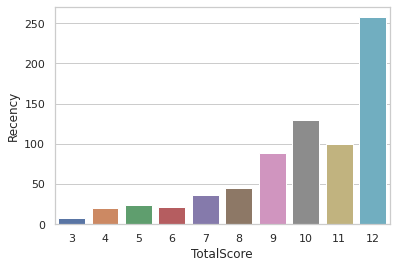

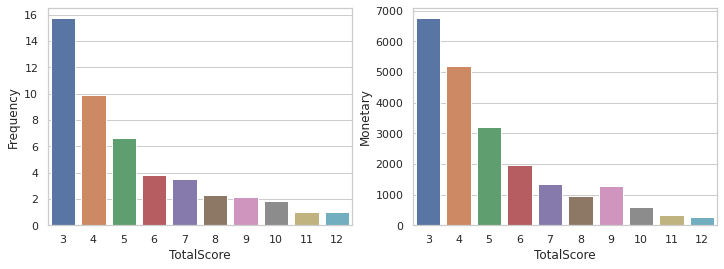

In [ ]:
sns.barplot(x=Score_Recency['TotalScore'],y=Score_Recency['Recency'])

plt.figure(constrained_layout=True, figsize=(12, 4))

plt.subplot(1,2,1)
sns.barplot(x=Score_Frequency['TotalScore'],y=Score_Frequency['Frequency'])

plt.subplot(1,2,2)
sns.barplot(x=Score_Monetatry['TotalScore'],y=Score_Monetatry['Monetary'])
plt.subplots_adjust(wspace = 0.2)

# COHORT ANALYSIS
- It is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis.
- A cohort is a group of users who share a common characteristic. For example, all users with the same Acquisition Date belong to the same cohort. 
- The retention rate show the percentage of customers return in the following months after the their first purchase.
- Customer acquisition cost is so expensive that we have to do remarketing our clients to retain them. If The retention rate is low, it means we have to spend more budget amount to acquire more customers to visit.

In [ ]:
def get_month(x): 
    return dt.datetime(x.year, x.month, 1)

In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

In [ ]:

# explain the difference between   apply - transform. In this case, use transform for CohortMonth.
# CohortMonth: the first time a customer came to our retail store.
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')

In [ ]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [ ]:
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df['CohortIndex'] = years_diff * 12 + months_diff + 1

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6.0,2010-12-01 13:04:00,2.95,12662.0,Germany,17.7,2010-12-01,2010-12-01,1
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6.0,2010-12-01 13:04:00,2.55,12662.0,Germany,15.3,2010-12-01,2010-12-01,1
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12.0,2010-12-01 13:04:00,0.85,12662.0,Germany,10.2,2010-12-01,2010-12-01,1
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12.0,2010-12-01 13:04:00,1.65,12662.0,Germany,19.8,2010-12-01,2010-12-01,1
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12.0,2010-12-01 13:04:00,1.95,12662.0,Germany,23.4,2010-12-01,2010-12-01,1


In [ ]:
## grouping customer berdasarkan masing masing cohort
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()
# To solve the problem when ploting heatmap diagram below.
cohort_data['CohortMonth'] = cohort_data['CohortMonth'].dt.date
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')

### Observation:
- CohortMonth of 2010-12-01 indicates 949 distinct customers when they first came (CohortIndex 1), 
- The following month (CohortIndex 2) has 363 repeat customers, so on. 

In [ ]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,18.0,9.0,7.0,12.0,11.0,11.0,8.0,11.0,8.0,9.0,11.0,16.0,4.0
2011-01-01,19.0,6.0,7.0,1.0,6.0,8.0,4.0,6.0,3.0,6.0,8.0,1.0,NaN
2011-02-01,4.0,NaN,1.0,2.0,NaN,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN
2011-03-01,5.0,1.0,2.0,NaN,2.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
2011-04-01,5.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2011-05-01,5.0,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-01,3.0,NaN,2.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,7.0,1.0,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,6.0,1.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Observation:
- The graph show customer numbers as percentage

In [ ]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(2) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,50.0,39.0,67.0,61.0,61.0,44.0,61.0,44.0,50.0,61.0,89.0,22.0
2011-01-01,100.0,32.0,37.0,5.0,32.0,42.0,21.0,32.0,16.0,32.0,42.0,5.0,NaN
2011-02-01,100.0,NaN,25.0,50.0,NaN,NaN,50.0,NaN,50.0,50.0,NaN,NaN,NaN
2011-03-01,100.0,20.0,40.0,NaN,40.0,20.0,40.0,20.0,20.0,NaN,NaN,NaN,NaN
2011-04-01,100.0,20.0,40.0,20.0,20.0,40.0,20.0,20.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,NaN,20.0,20.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,NaN,67.0,67.0,33.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,14.0,57.0,29.0,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,17.0,67.0,33.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


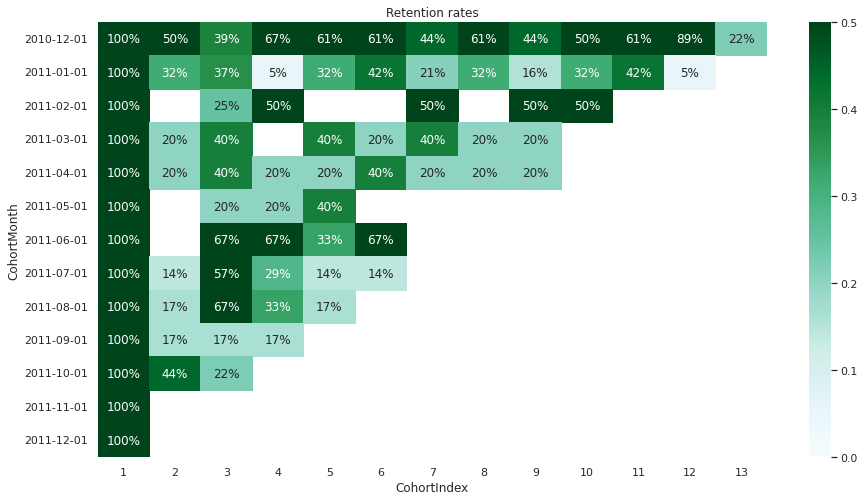

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
            annot = True,
            fmt = '.0%',
            vmin = 0.0, vmax = 0.5,
            cmap = 'BuGn')
plt.show()